In [30]:
import scipy
from scipy import ndimage as ndi
import scipy.optimize
from skimage import measure
from skimage import data
from skimage import filters
from skimage import feature
from skimage.filters.rank import entropy
from skimage.morphology import disk
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import png
import itertools
from matplotlib.pyplot import imshow

In [4]:
%matplotlib inline

In [48]:
target_yellow = np.array([199, 159, 50])
target_green = np.array([36, 64, 33])
target_blue = np.array([16, 64, 122])
norm_yellow = target_yellow / target_yellow[0]
norm_green = target_green / target_green[0]
norm_blue = target_blue / target_blue[0]
norms = [norm_yellow, norm_green, norm_blue]
targets = [target_yellow, target_green, target_blue]

In [112]:
hue = np.array([1,0.8,0.8])

In [113]:
img_orig = ndi.imread("./sign.jpg")
new = np.array(img_orig[:,:]*hue, dtype="uint8")
img = new

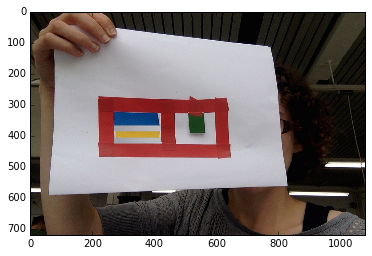

In [114]:
imshow(img_orig)

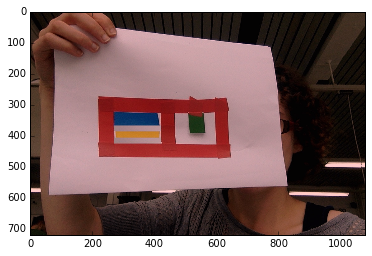

In [115]:
imshow(img)

In [116]:
# ar,ag,ab = np.mean(img[:,:,0]),np.mean(img[:,:,1]),np.mean(img[:,:,2])
# print ar/ag, ar/ab
# level = np.mean([ar, ag, ab])
# if level < 90:
#     bright = [90 - level for i in range(3)]
#     img = np.array(img[:,:]+bright, dtype="uint8")

In [117]:
im = filters.gaussian_filter(img, sigma=256 / (40. * 20))

/Users/admin/miniconda2/lib/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


In [118]:
blobs = im < im.mean()
red_blobs = blobs[:,:,0][:,:,None]
blue_blobs = blobs[:,:,2][:,:,None]

In [128]:
def score_colours(feats):
    avgs = [np.array((np.mean(ft[:,:,0]),np.mean(ft[:,:,1]),np.mean(ft[:,:,2]))) for ft in feats]
    norm_colours = [c/c[0] for c in avgs]
    order = list(itertools.permutations([norm_yellow,norm_green,norm_blue]))
    scores = np.array([np.sum(np.array((np.array(norm_colours) - np.array(targets))**2)) for targets in order])
    return order[np.argmin(scores)]

In [129]:
def get_targets(ntargets):
    result = []
    for t in ntargets:
        for i,n in enumerate(norms):
            if all(n == t):
                result.append(targets[i])
                break
    return result

In [130]:
def get_diffs(feats, ntargets):
    avgs = [np.array((np.mean(ft[:,:,0]),np.mean(ft[:,:,1]),np.mean(ft[:,:,2]))) for ft in feats]
    target_colours = get_targets(ntargets)
    return np.array(avgs) - np.array(target_colours)

In [131]:
def get_total_diffs(feats, ntargets):
    diffs = get_diffs(feats, ntargets)
    return np.array([np.sum(diffs[:,i]) for i in range(3)])

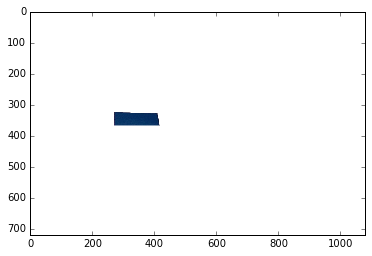

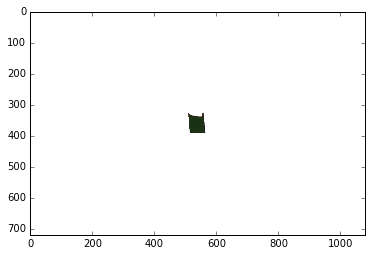

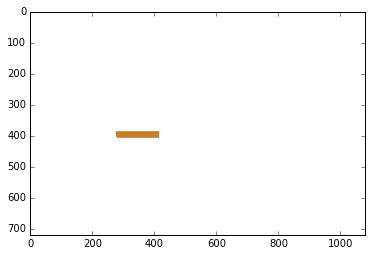

In [132]:
features = []
for blobs in [red_blobs, blue_blobs]:
    all_labels, n = measure.label(blobs, return_num=True)
    for i in range(n):
        blob = np.ma.masked_where(all_labels != i, all_labels)
        m = np.repeat(blob.mask,3,axis=2)
        ft = np.ma.masked_array(img, mask=m)
        ft.fill_value = 255
        avr,avg,avb = np.mean(ft[:,:,0]),np.mean(ft[:,:,1]),np.mean(ft[:,:,2])
        colour = np.array([avr,avg,avb])
        norm_colour = colour / colour[0]
#         avgs = np.sort([avr,avb,avg])
#         def_colour = avgs[-1] / (avgs[0]+avgs[1]) > 0.9
#         max_std = np.max([np.std(ft[:,:,0]),np.std(ft[:,:,1]),np.std(ft[:,:,2])])
        score = (avr/avg) / (avr/avb)
        score = score if score > 1 else 1/score
#         if def_colour and ft.count() > 3000 and max_std < 30 and score > 1.5:
        if ft.count() > 3000 and ft.count() < 20000 and score > 1.5:
            features.append((ft, score))
            imshow(ft.filled())
            plt.show()
features = sorted(features, key=lambda x: x[1])[:3]
features = [f[0] for f in features]
total_diffs = get_total_diffs(features, score_colours(features))/255

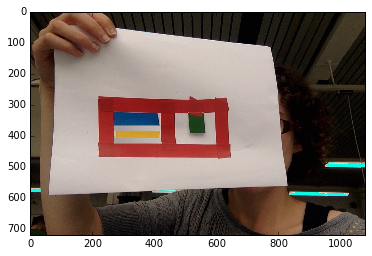

In [136]:
imshow(np.array(img[:,:]*(1-total_diffs), dtype="uint8"))